<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Deep Learning School of the MIPT Faculty of Physics and Technology</b></h3>

<h3 style="text-align: center;"><b>Fully connected and convolutional neural networks</b></h3>

In this lesson, you will have to practice building neural networks using the Pwtorch library. We will do this on several datasets.








In [2]:
! pip install torch

In [3]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Part 1. Moons Dataset

Let's generate a dataset and look at it!

In [4]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

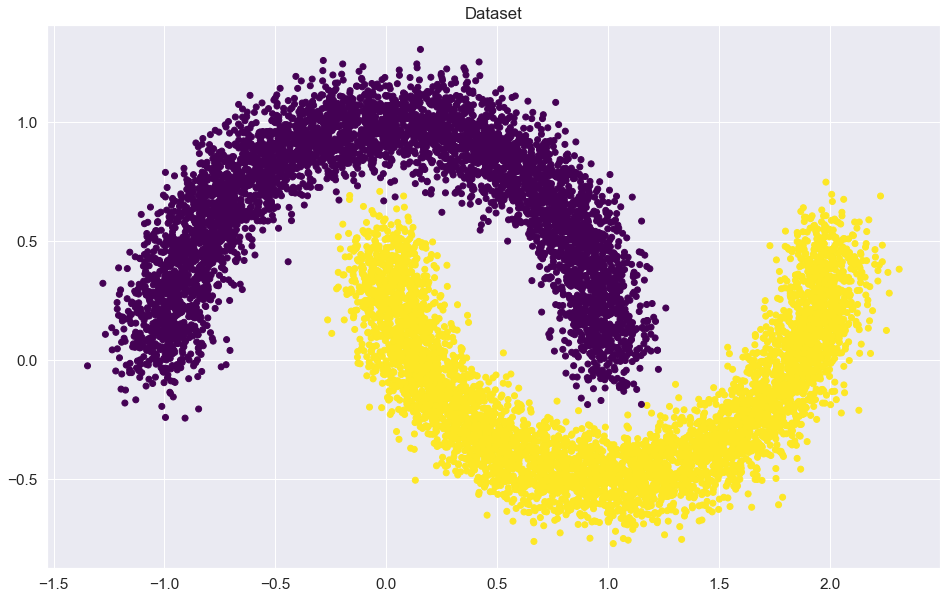

In [5]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Let's make a train/test split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Loading data
In Pwtorch, data loading usually takes place on the fly (sometimes datasets do not fit into RAM). Two entities `Dataset` and `DataLoader' are used for this.

1. 'Dataset` loads each object individually.

2. 'DataLoader` groups objects from `Dataset` into butches.

Since our dataset is quite small, we will use `TensorDataset'. All we need is to translate from the numpy array into a tensor with the type `torch.float32'.

### Create tensors with training and test data

In [7]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

Make `Dataset` and `DataLoader`. 

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Reminder**
Let's remember what happens in logistic regression. At the input, we have an object-feature matrix X and a column-vector $y$ – labels of $\{0, 1\}$ for each object. We want to find such a matrix of weights $W$ and bias $b$ (bias) that our model $XW +b$ will somehow predict the class of the object. As you can see in the output, our model can output a number in the range from $(-\infty;\infty)$. This output is usually called "logits" (logits). We need to translate it to an interval from $[0;1]$ in order for it to give us the probability that the object belongs to the cash register one, it is also better that this function is monotonic, is quickly calculated, has a derivative and $-\infty$ has the value $0$, and $+\infty$ had a value of $1$. Such a class of functions is called sigmoids. Most often , as a sigmoid , they take
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Task. Implementation of logistic regression

You need to write a module in PyTorch implementing $logits = XW + b$, where $W$ and $b$ are the parameters (`nn.Parameter`) of the model. In other words, here we are implementing the `nn.Linear` module with our own hands (its use is prohibited at this point). Initialize the weights with a normal distribution (`torch.randn').

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, requires_grad=True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1, requires_grad=True))
        # print(out_features)
    def forward(self, x):
        x = x @ self.weights.T
        if self.bias:
            x += self.bias_term
        return x

In [10]:
# H=5
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

Model parameters

In [11]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([-0.3693, -0.8403], requires_grad=True),
 Parameter containing:
 tensor([1.2425], requires_grad=True)]

### Implementation of the learning cycle

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

sig = nn.Sigmoid()

for epoch in range(max_epochs):        # <----------- iterate over the dataset several times
# for epoch in range(1):
    for it, (X_batch, y_batch) in enumerate(train_dataloader): # <------ iterating on the dataset. Since we use SGD and not GD, we take ba
        H = X_batch.shape[0]
        optimizer.zero_grad()   # <------------- zeroing out the gradients of the model
        # print(X_batch, y_batch)
        # print()
        outp =  linear_regression(X_batch) # <------------- Use linear_regression to get outputs
        loss = loss_function(outp, y_batch) # <------------- Compute loss
        loss.backward()                      # <------------------- calculate gradients
        losses.append(loss.detach().flatten()[0])
        optimizer.step()                    # <------------------ making a step of gradient descent
        probabilities = sig(outp) # Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:    # <------------------- in the case of convergence, we exit the cycle
        break

C:\Users\user\AppData\Local\Temp\ipykernel_14976\1876851447.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3281.)
  x = x @ self.weights.T  # YOUR CODE GOES HERE


Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.890625
Iteration: 200
Batch accuracy: 0.875
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.8984375
Iteration: 500
Batch accuracy: 0.9140625

Iteration: 578.Convergence. Stopping iterations.


### Visualize the results

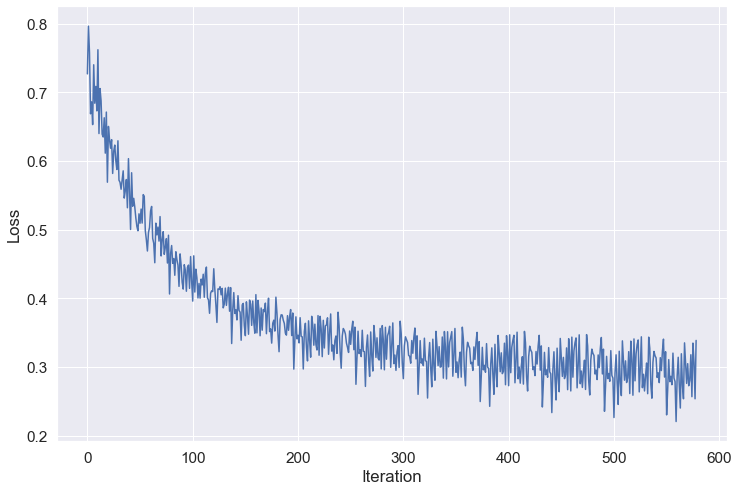

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

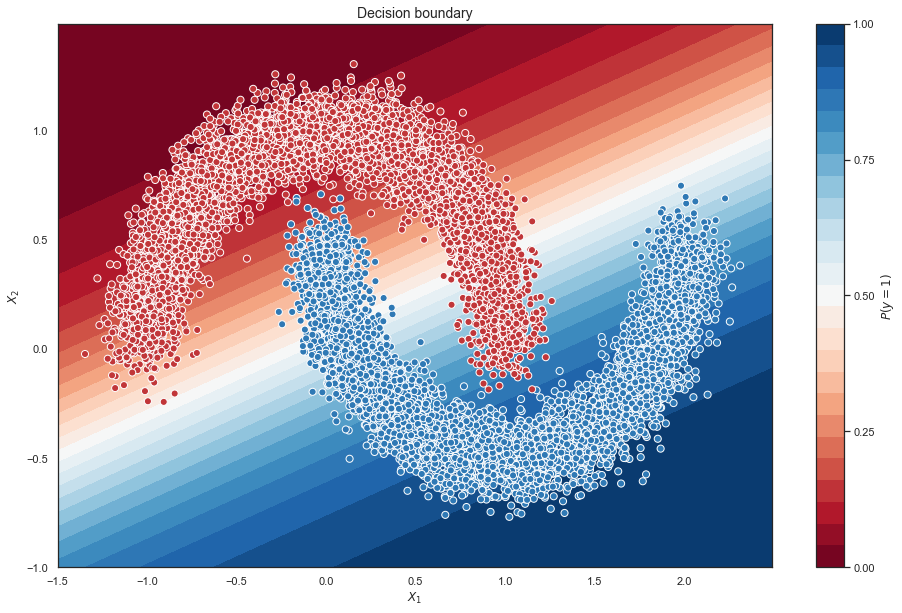

In [14]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Implement predict and calculate accuracy on test.

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = 1*(sig(model(x_batch)) > 0.5) # Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [16]:
from sklearn.metrics import accuracy_score
# Compute total accuracy
accuracy_score(y_val_t, predict(val_dataloader, linear_regression))

0.8796

# Part 2. Dataset MNIST
The MNIST dataset contains handwritten numbers. Download the dataset and create DataLoader-s. An example can be found in a seminar on fully connected neural networks.

In [18]:
! pip install torchvision

In [19]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=64)
valid_dataloader =  DataLoader(val_dataset, batch_size=64)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



## Part 2.1. Fully connected neural networks
First, let's solve MNIST using a fully connected neural network.

In [20]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### A simple fully connected neural network 

Create a fully connected neural network using the Sequential class. The network consists of:
* Flattening the matrix into a vector (nn.Flatten);
* Two hidden layers of 128 neurons with nn activation.ELU;
* Output layer with 10 neurons.

Set the loss for training (cross-entropy).


In [ ]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [ ]:
criterion = nn.CrossEntropyLoss() # Select a loss function
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [26]:
! pip install tensorflow-gpu

In [28]:
torch.cuda.is_available()

False

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)
Let's look at the code below, which will be suitable for 90% of tasks in the future.


```python
for epoch in range(max_epochs): # <--------------- iterate over the dataset several times
    for k, dataloader in loaders.items(): # <----- multiple dataloader for train/valid /test
        for x_batch, y_batch in dataloader: # <--- iterating on the dataset. Since we use SGD and not GD, we take butches of a given size
            if k == "train":
                model.train() # <------------------ switching the model to train mode
                optimizer.zero_grad() # <--------- zeroing out the gradients of the model
                outp = model(x_batch)
loss = criterion(outp, y_batch) # <-we count the "loss" for logistic regression
                loss.backward() # <--------------- counting gradients
                optimizer.step() # <-------------- making a step of gradient descent
            else:  # <----------------------------- test/eval
                model.eval() # <------------------ switching the model to eval mode
                with torch.no_grad(): # <--------- DON'T count gradients
                    outp = model(x_batch) # <------------- we get "logits" from the model
            count_metrics(outp, y_batch) # <-------------- counting metrics
```

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        # print(k)
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            # print(y_batch)
            if k == "train":
                # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                # Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():  # <--------- DON'T calc gradients
                    outp = model(x_batch)  
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  x_batch.shape[0]
            epoch_correct += correct #.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward() 
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8959166407585144
Loader: valid. Accuracy: 0.9434000253677368
Epoch: 2
Loader: train. Accuracy: 0.9513833522796631
Loader: valid. Accuracy: 0.9570000171661377
Epoch: 3
Loader: train. Accuracy: 0.962933361530304
Loader: valid. Accuracy: 0.9607999920845032
Epoch: 4
Loader: train. Accuracy: 0.9695166945457458
Loader: valid. Accuracy: 0.9639999866485596
Epoch: 5
Loader: train. Accuracy: 0.9746333360671997
Loader: valid. Accuracy: 0.9684000015258789
Epoch: 6
Loader: train. Accuracy: 0.9778833389282227
Loader: valid. Accuracy: 0.9692000150680542
Epoch: 7
Loader: train. Accuracy: 0.9801666736602783
Loader: valid. Accuracy: 0.9728999733924866
Epoch: 8
Loader: train. Accuracy: 0.9816166758537292
Loader: valid. Accuracy: 0.9726999998092651
Epoch: 9
Loader: train. Accuracy: 0.98294997215271
Loader: valid. Accuracy: 0.9725000262260437
Epoch: 10
Loader: train. Accuracy: 0.9849666953086853
Loader: valid. Accuracy: 0.9779000282287598


### Test different activation functions.
Try different activation functions. For each activation function, calculate the validation accuracy array. It is better to implement this in the form of a function that takes activation as input and receives an array from accuracies.

In [ ]:
import time

In [ ]:
# wrap into a function that returns a list of accuracies

def test_activation_function(activation_):

    model_ = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation_(),
        nn.Linear(128, 128),
        activation_(),
        nn.Linear(128, 128),
        activation_(),
        nn.Linear(128, 10)
    )

    criterion = nn.CrossEntropyLoss() # Select a loss function
    optimizer = torch.optim.Adam(model_.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    time_ = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            t1 = time.time()
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model_.train() 
                    optimizer.zero_grad()
                    outp = model_(x_batch)
                else:
                    # Set model to ``eval`` mode and calculate outputs
                    model_.eval()
                    with torch.no_grad():  # <--------- DON'T calc gradients
                        outp = model_(x_batch)
                preds = outp.argmax(-1)
                correct =  (preds == y_batch).sum()
                all =  x_batch.shape[0]
                epoch_correct += correct #.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    # Calculate gradients and make a step of your optimizer
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            dt = time.time() - t1
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}, time: {dt}")
            accuracy[k].append(epoch_correct/epoch_all)
            time_[k].append(dt)
    return accuracy["valid"]

In [ ]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
elu_accuracy = test_activation_function(nn.ELU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8613166809082031, time: 11.38574504852295
Loader: valid. Accuracy: 0.8787000179290771, time: 1.6065404415130615
Epoch: 2
Loader: train. Accuracy: 0.8878999948501587, time: 11.531546115875244
Loader: valid. Accuracy: 0.8859999775886536, time: 1.5110900402069092
Epoch: 3
Loader: train. Accuracy: 0.8941500186920166, time: 12.19927167892456
Loader: valid. Accuracy: 0.8894000053405762, time: 2.913191795349121
Epoch: 4
Loader: train. Accuracy: 0.8980333209037781, time: 10.76839566230774
Loader: valid. Accuracy: 0.8906999826431274, time: 1.5025975704193115
Epoch: 5
Loader: train. Accuracy: 0.9007999897003174, time: 10.74974012374878
Loader: valid. Accuracy: 0.8888000249862671, time: 1.5440568923950195
Epoch: 6
Loader: train. Accuracy: 0.9029833078384399, time: 11.811935186386108
Loader: valid. Accuracy: 0.8895999789237976, time: 1.579395055770874
Epoch: 7
Loader: train. Accuracy: 0.9045666456222534, time: 10.58695387840271
Loader: valid. Accuracy: 0.8902999

### Accuracy
Let's plot the accuracy/epoch graph for each activation function.

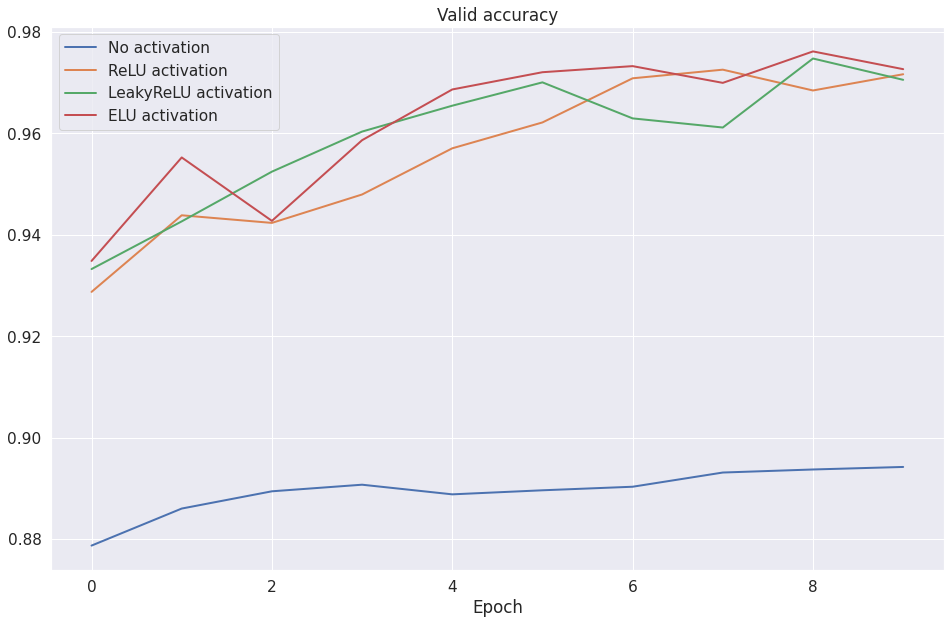

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)
max_epochs = 10
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

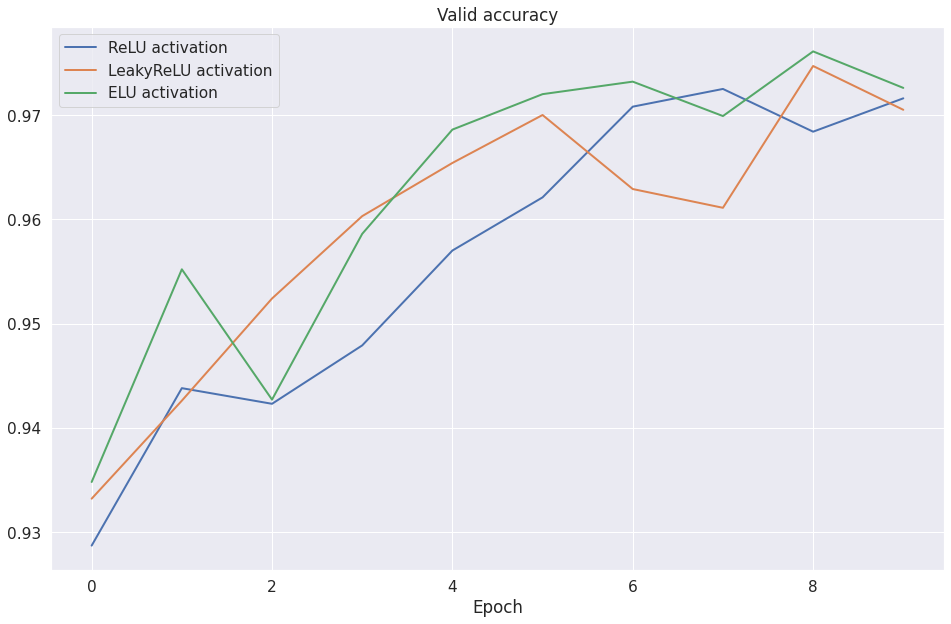

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Part 2.2 Convolutional neural networks

### Cores
First, let's work a little with the very concept of the convolution kernel.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-10-29 18:14:05--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-10-29 18:14:06--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   123KB/s    in 0.4s    

2022-10-29 18:14:08 (123 KB/s) - ‘sample_photo.jpg’ saved [49337/4

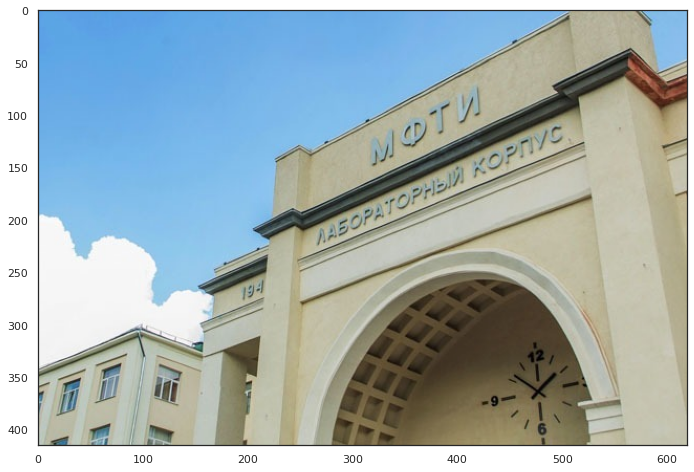

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Try to see how different convolutions affect the photo. For example, try
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
kernels_dict_ = {
    "А": torch.tensor([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]
        ]),
    "Б": torch.tensor([
        [0, 1, 0],
        [0, -2, 0],
        [0, 1, 0]
        ]),
    "В": torch.tensor([
        [0, 0, 0],
        [1, -2, 1],
        [0, 0, 0]
        ]),
    "Г": torch.tensor([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
        ]),
    "Д": torch.tensor([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
        ]),
    "Е": torch.tensor([
        [0.0625, 0.125, 0.0625],
        [0.125, 0.25, 0.125],
        [0.0625, 0.125, 0.0625]
        ])
    }

In [ ]:
def test_kernels(kernels_dict):
  for id, kernel_tensor in kernels_dict.items():
    print(id)
    sns.heatmap(kernel_tensor, annot=True, cbar=False, cmap='vlag', center=0)
    plt.show()

    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = kernel_tensor.reshape(1, 1, 3, 3).type(torch.float32)

    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]  #
    plt.figure(figsize=(12, 8))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3
    
    
    plt.imshow(result_np)
    plt.show()  

А


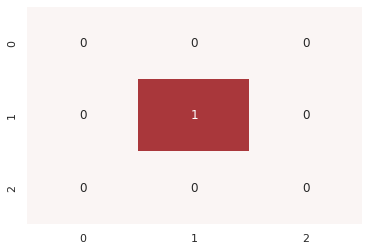

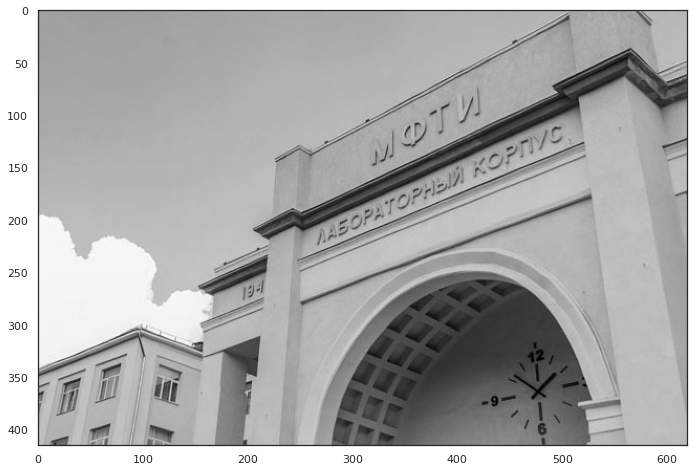

Б


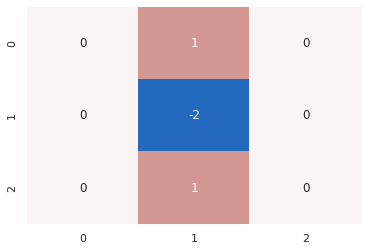

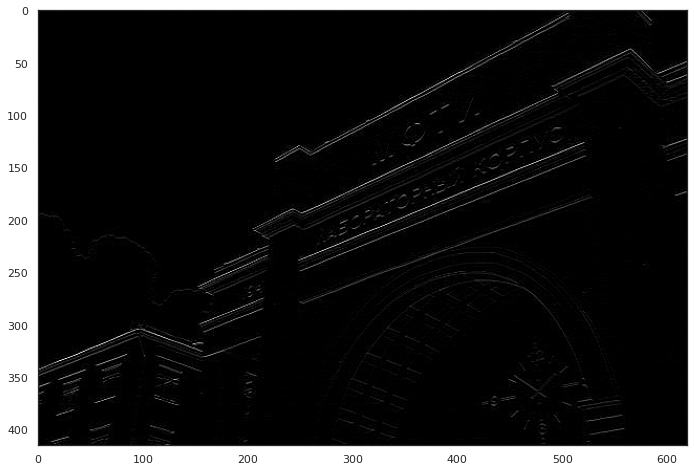

В


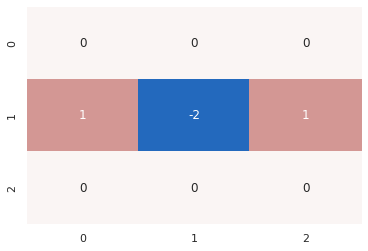

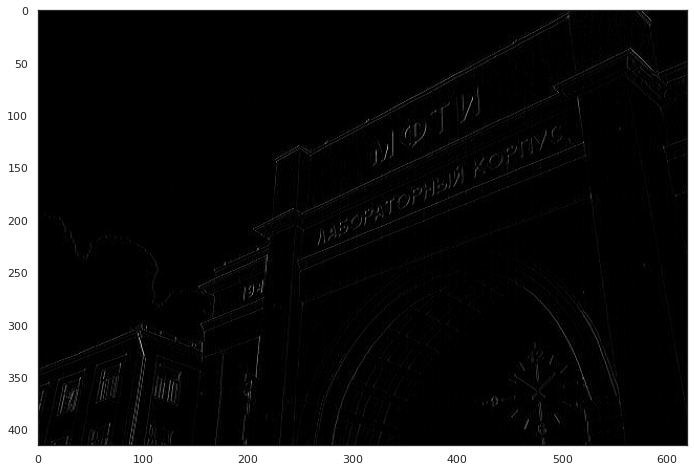

Г


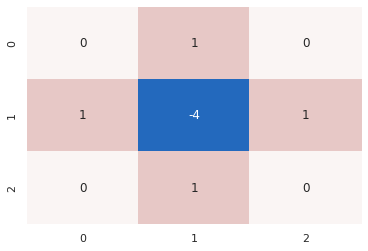

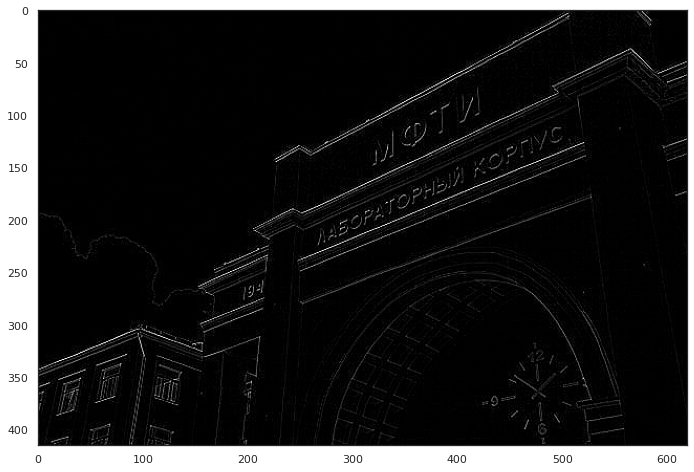

Д


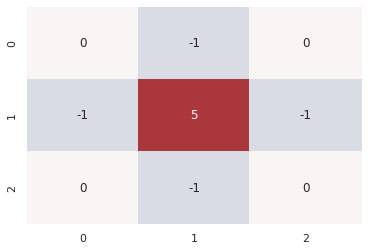

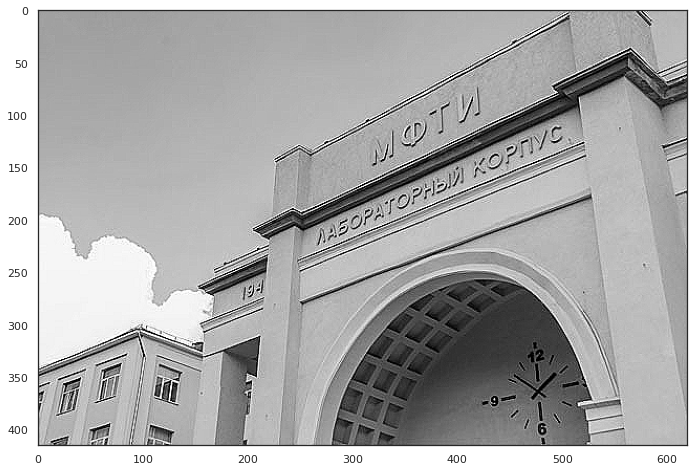

Е


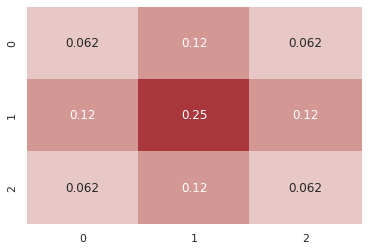

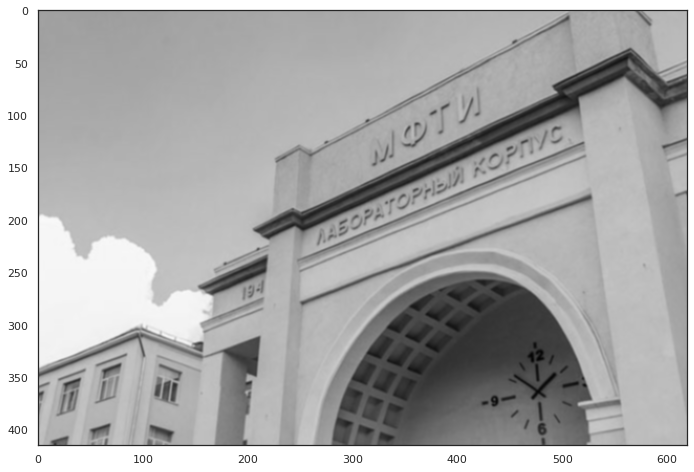

In [ ]:
test_kernels(kernels_dict_)

In [ ]:
kernels_dict_my = {
    "G": torch.tensor([
        [-1, 0, 0],
        [0, 2, 0],
        [0, 0, -1]
        ]),
    "H": torch.tensor([
        [0.0000, 0.0000, -1.0000],
        [0.0000, 2.0000, 0.0000],
        [-1.0000, 0.0000, 0.0000]
        ]),
    }

G


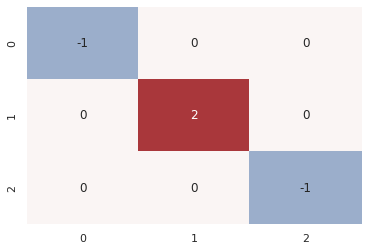

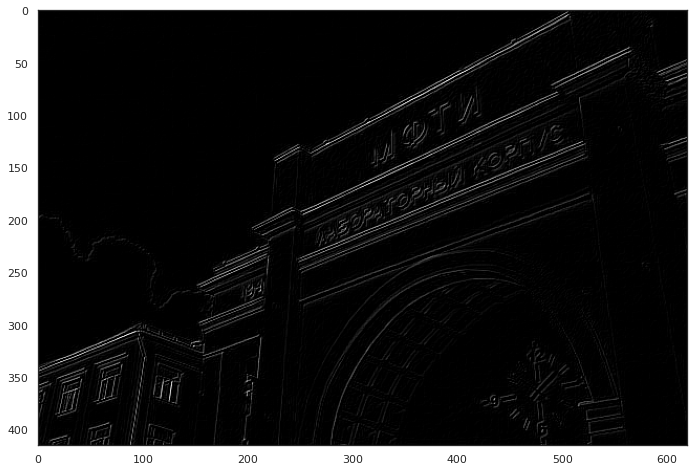

H


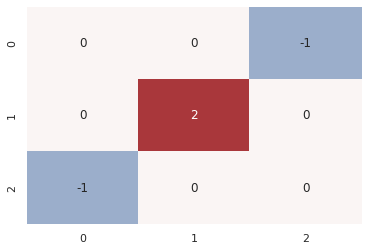

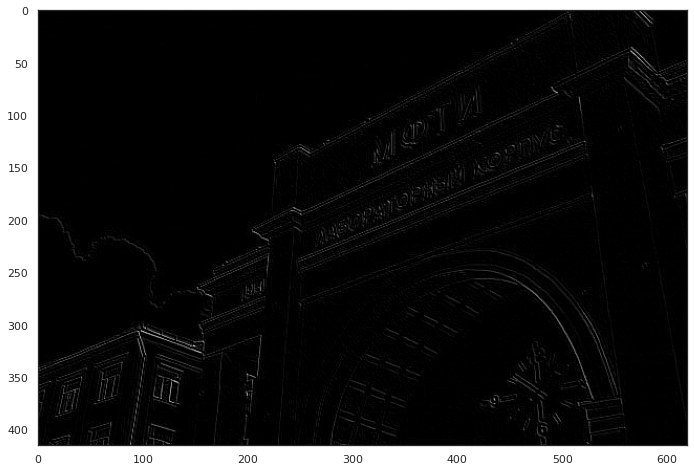

In [ ]:
test_kernels(kernels_dict_my)

How can we describe the actions of the kernels listed above?

1) Blur = Е

2) Increase sharpness = Д

3) Identical transformation = А

4) Selection of vertical borders = В

5) Selection of horizontal borders = Б

6) Border selection = Г

### Task. Implement LeNet

If we make the parameters of the convolutions trainable, we can achieve good results for computer vision tasks. Implement the LeNet architecture, proposed back in 1998!
This time, use a modular structure (without the help of the Sequential class). 

Our neural network will consist of
* 3x3 convolutions (1 card at the input, 6 at the output) with ReLU activation;
* MaxPooling-a 2x2;
* 3x3 convolutions (6 cards at the input, 16 at the output) with ReLU activation;
* MaxPooling-a 2x2;
* Flattening (nn.Flatten);
* Fully connected layer with 120 neurons and ReLU activation;
* Fully connected layer with 84 neurons and ReLU activation;
* Output layer of 10 neurons.

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        # break
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ...
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Task. Train CNN
Use the training code you wrote for a fully connected neural network.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
            else:
                model.eval()
                with torch.no_grad():  # <--------- DON'T calc gradients
                    outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct =  (preds == y_batch.to(device)).sum()
            all =  x_batch.to(device).shape[0]
            epoch_correct += correct #.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9142833352088928
Loader: valid. Accuracy: 0.9745000004768372
Epoch: 2
Loader: train. Accuracy: 0.9757500290870667
Loader: valid. Accuracy: 0.9817000031471252
Epoch: 3
Loader: train. Accuracy: 0.9837999939918518
Loader: valid. Accuracy: 0.9845999479293823
Epoch: 4
Loader: train. Accuracy: 0.9878166913986206
Loader: valid. Accuracy: 0.9839999675750732
Epoch: 5
Loader: train. Accuracy: 0.9905333518981934
Loader: valid. Accuracy: 0.9853000044822693
Epoch: 6
Loader: train. Accuracy: 0.9923000335693359
Loader: valid. Accuracy: 0.9870999455451965
Epoch: 7
Loader: train. Accuracy: 0.9941499829292297
Loader: valid. Accuracy: 0.986799955368042
Epoch: 8
Loader: train. Accuracy: 0.9946666955947876
Loader: valid. Accuracy: 0.986799955368042
Epoch: 9
Loader: train. Accuracy: 0.9949333667755127
Loader: valid. Accuracy: 0.9878000020980835
Epoch: 10
Loader: train. Accuracy: 0.9962999820709229
Loader: valid. Accuracy: 0.9878999590873718


In [ ]:
lenet_accuracy = accuracy["valid"]

Let's compare with the previous paragraph

In [ ]:
lenet_accuracy = [i.to('cpu').item() for i in lenet_accuracy]
lenet_accuracy

[0.9745000004768372,
 0.9817000031471252,
 0.9845999479293823,
 0.9839999675750732,
 0.9853000044822693,
 0.9870999455451965,
 0.986799955368042,
 0.986799955368042,
 0.9878000020980835,
 0.9878999590873718]

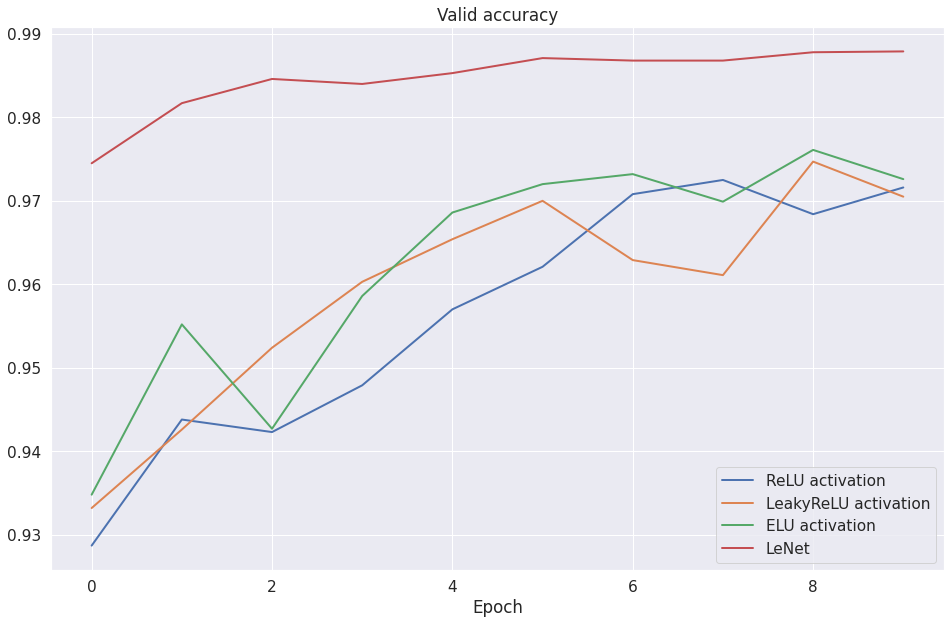

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()